<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/Pareto_NBD_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 584 kB 4.9 MB/s 


In [2]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt
import plotly.express as px
import xlrd
import pandas as pd
import warnings
import lifetimes
import dill as pickle
from sklearn.cluster import KMeans
from lifetimes import ParetoNBDFitter, GammaGammaFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from sklearn.metrics import mean_squared_error, r2_score
import math
from math import sqrt
warnings.filterwarnings("ignore")
import datetime
np.random.seed(42)

In [3]:
data = pd.read_excel("Retail_cleaned_dataset.xlsx")

In [4]:
data["TotalPrice"] = data["Quantity"]*data["Price"]

In [5]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2019-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2019-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2019-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2019-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2019-12-01 07:45:00,1.25,13085,United Kingdom,30.0


In [6]:
rfm_summary = lifetimes.utils.summary_data_from_transaction_data(data, "CustomerID", "InvoiceDate", "TotalPrice")

In [7]:
rfm_summary.reset_index(inplace = True)

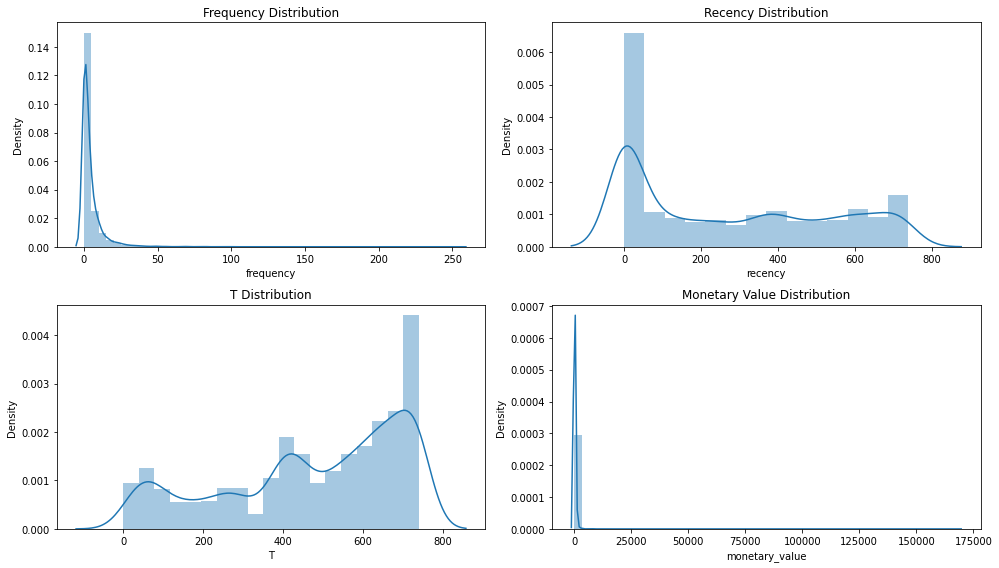

In [8]:
#plotting the distribution
plt.figure(figsize=(14,8))
plt.subplot(221)
sns.distplot(rfm_summary["frequency"])
plt.title("Frequency Distribution")
plt.subplot(222)
sns.distplot(rfm_summary["recency"])
plt.title("Recency Distribution")
plt.subplot(223)
sns.distplot(rfm_summary["T"])
plt.title("T Distribution")
plt.subplot(224)
sns.distplot(rfm_summary["monetary_value"])
plt.title("Monetary Value Distribution")
plt.tight_layout()

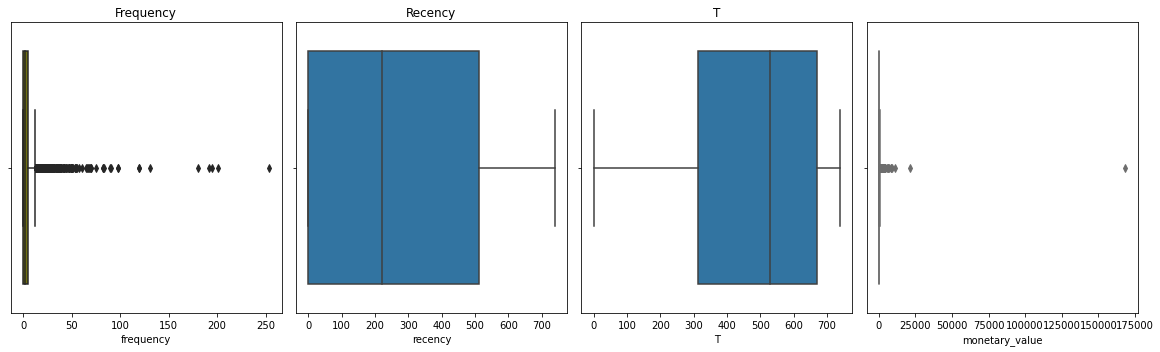

In [9]:
plt.figure(figsize=(16,5))
plt.subplot(141)
sns.boxplot(rfm_summary["frequency"], color = "olive")
plt.title("Frequency")
plt.subplot(142)
sns.boxplot(rfm_summary["recency"])
plt.title("Recency")
plt.subplot(143)
sns.boxplot(rfm_summary["T"])
plt.title("T")
plt.subplot(144)
sns.boxplot(rfm_summary["monetary_value"], color = "salmon")

plt.tight_layout()

In [10]:
rfm_summary.describe(percentiles = [0.01,0.1,0.25,0.50,0.75,0.90,0.99])

,CustomerID,frequency,recency,T,monetary_value
count,5878.000000,5878.000000,5878.000000,5878.000000,5878.000000
mean,15315.313542,4.632358,273.647669,474.551718,312.996561
std,1715.572666,9.999783,259.242435,223.394778,2255.743170
min,12346.000000,0.000000,0.000000,0.000000,0.000000
1%,12405.770000,0.000000,0.000000,15.000000,0.000000
10%,12936.700000,0.000000,0.000000,89.000000,0.000000
25%,13833.250000,0.000000,0.000000,313.000000,0.000000
50%,15314.500000,2.000000,221.000000,530.000000,207.117500
75%,16797.750000,5.000000,512.000000,669.000000,368.045909
90%,17696.300000,11.000000,668.000000,731.000000,591.139417


In [11]:
rfm_summary.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346,7.0,401.0,726.0,11066.637143
1,12347,7.0,402.0,404.0,615.714286
2,12348,4.0,363.0,438.0,449.310000
3,12349,3.0,571.0,589.0,1120.056667
4,12350,0.0,0.0,310.0,0.000000


**Pareto/NBD Model**

In [12]:
def get_model(data, penalizer_val, time):
    
    pareto_result = data.copy()

    pareto_model = ParetoNBDFitter(penalizer_coef = penalizer_val)
    pareto_model.fit(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

    #calculating the predicted_purchases

    t = time

    pareto_result["predicted_purchases"] = pareto_model.conditional_expected_number_of_purchases_up_to_time(t, pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])


    pareto_result["Actual_Purchases"] = pareto_result["frequency"]/pareto_result["recency"]*time

    #filling the null values
    pareto_result["Actual_Purchases"].fillna(0, inplace = True)


    #calculating the error
    pareto_result["Prediction_Error"] = pareto_result["Actual_Purchases"]-pareto_result["predicted_purchases"]

    #calcuating the purchase prediction error
    pareto_mse_purchase = mean_squared_error(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"])
    pareto_r2_purchase = r2_score(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"])
    pareto_rmse_purchase = sqrt(mean_squared_error(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"]))
    pareto_avg_error_purchase = pareto_result["Prediction_Error"].mean()
    
    #printing the purchase prediction error
    print("Predicted Purchase Mean Squared Error: %s" %(pareto_mse_purchase))
    print("Predicted Purchase R2 Score: %s" %(pareto_r2_purchase))
    print("Predicted Purchase Root Mean Squared Error: %s" %(pareto_rmse_purchase))
    print("Predicted Purchase Average Purchases Error: %s" %(pareto_avg_error_purchase))
    
    
    #plotting the prediction v/s actual purchase plot
    plt.figure(figsize=(6,4))
    plt.errorbar(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"], yerr=pareto_result["Prediction_Error"], fmt='o', color='darkseagreen',
                 ecolor='grey', elinewidth=1.5, capsize=0, alpha = 0.2);
    plt.title("Prediction v/s Actual")

Predicted Purchase Mean Squared Error: 2.2178054572100874
Predicted Purchase R2 Score: 0.060510353555273455
Predicted Purchase Root Mean Squared Error: 1.4892298201453285
Predicted Purchase Average Purchases Error: 0.23184043664196166


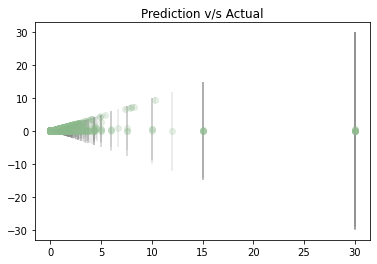

In [13]:
get_model(rfm_summary, 0.001, 30)

In [14]:
pareto_model = lifetimes.ParetoNBDFitter(penalizer_coef = 0.1)

In [15]:
pareto_model.fit(rfm_summary["frequency"],rfm_summary["recency"],
                rfm_summary["T"])

<lifetimes.ParetoNBDFitter: fitted with 5878 subjects, alpha: 72.03, beta: 385.66, r: 0.74, s: 0.18>

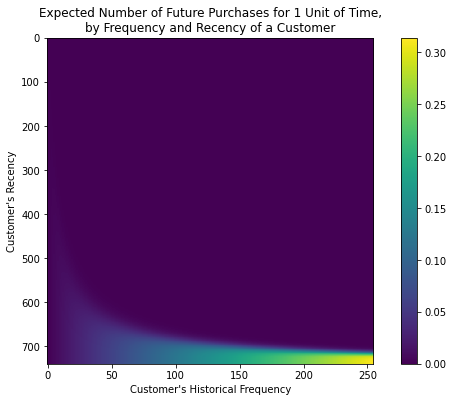

In [16]:
plt.figure(figsize=(10,6))
plot_frequency_recency_matrix(pareto_model)

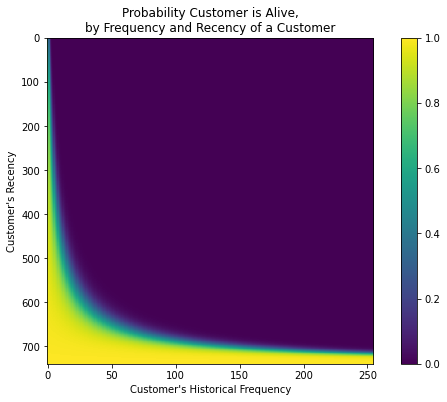

In [17]:
plt.figure(figsize=(10,6))
plot_probability_alive_matrix(pareto_model)

In [18]:
pareto_result = rfm_summary.copy()

In [19]:
pareto_result["p_not_alive"] = 1-pareto_model.conditional_probability_alive(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])
pareto_result["p_alive"] = pareto_model.conditional_probability_alive(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

In [20]:
pareto_result.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449
4,12350,0.0,0.0,310.0,0.000000,0.167712,0.832288


In [21]:
t = 30
pareto_result["predicted_purchases"] = pareto_model.conditional_expected_number_of_purchases_up_to_time(t, pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

In [22]:
pareto_result

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606
4,12350,0.0,0.0,310.0,0.000000,0.167712,0.832288,0.048093
...,...,...,...,...,...,...,...,...
5873,18283,18.0,656.0,659.0,142.666667,0.000541,0.999459,0.766602
5874,18284,0.0,0.0,431.0,0.000000,0.222904,0.777096,0.034122
5875,18285,0.0,0.0,661.0,0.000000,0.309941,0.690059,0.020808
5876,18286,1.0,248.0,724.0,833.480000,0.201957,0.798043,0.052165


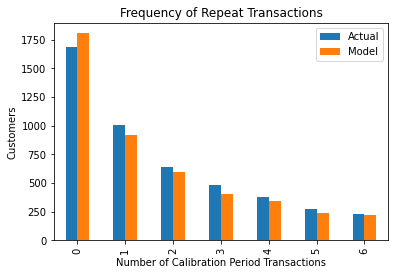

In [23]:
plot_period_transactions(pareto_model)

In [24]:
#dividing our dataset into training & holdout
pareto_summary_cal_holdout = calibration_and_holdout_data(data, "CustomerID", "InvoiceDate", 
                                                   calibration_period_end = '2021-06-08',
                                                  observation_period_end = '2021-12-09')

In [25]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,7.0,401.0,542.0,0.0,184.0
12347,3.0,158.0,220.0,4.0,184.0
12348,3.0,190.0,254.0,1.0,184.0
12349,2.0,182.0,405.0,1.0,184.0
12350,0.0,0.0,126.0,0.0,184.0


In [26]:
pareto_model.fit(pareto_summary_cal_holdout["frequency_cal"],
               pareto_summary_cal_holdout["recency_cal"],
               pareto_summary_cal_holdout["T_cal"])

<lifetimes.ParetoNBDFitter: fitted with 4960 subjects, alpha: 74.85, beta: 1619.38, r: 0.75, s: 0.69>

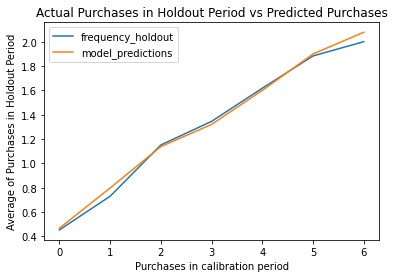

In [27]:
plot_calibration_purchases_vs_holdout_purchases(pareto_model, pareto_summary_cal_holdout)

In [28]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,7.0,401.0,542.0,0.0,184.0
12347,3.0,158.0,220.0,4.0,184.0
12348,3.0,190.0,254.0,1.0,184.0
12349,2.0,182.0,405.0,1.0,184.0
12350,0.0,0.0,126.0,0.0,184.0


In [29]:
pareto_result["actual30"] = pareto_result["frequency"]/pareto_result["recency"]*30

In [30]:
pareto_result["actual30"].fillna(0, inplace = True)

In [31]:
pareto_result["error"] = pareto_result["actual30"]-pareto_result["predicted_purchases"]

In [32]:
pareto_result.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988
4,12350,0.0,0.0,310.0,0.000000,0.167712,0.832288,0.048093,0.000000,-0.048093


In [33]:
def get_metrics(true, predicted, error):
    
    print("Mean Squared Error: %s"%(mean_squared_error(true, predicted)))
    print("Root Mean Squared Error: %s"%(sqrt(mean_squared_error(true, predicted))))
    print("R2 Score: %s"%(r2_score(true, predicted)))
    
    sns.scatterplot(true, predicted, size = error, color = "darkolivegreen")
    plt.title("Actual Purchase v/s Predicted Purchase")
    plt.show()

Mean Squared Error: 2.2178118875611887
Root Mean Squared Error: 1.489231979095664
R2 Score: 0.060507629579523825


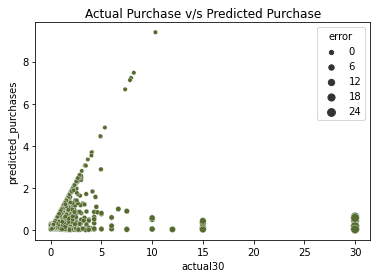

In [34]:
get_metrics(pareto_result["actual30"], pareto_result["predicted_purchases"], pareto_result["error"])

In [35]:
#Get the history alive plot to check whether the customer is alive or not

def get_history_alive(t_, data_, id_):
    
    individual_alive = data[data["CustomerID"] == id_]
    plot_history_alive(pareto_model, t = t_, transactions = individual_alive, datetime_col = "InvoiceDate",
                  freq = "D")

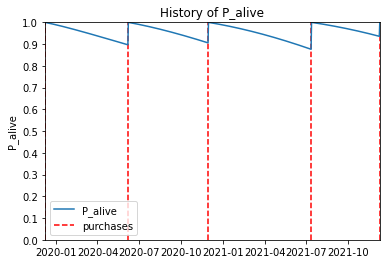

In [36]:
get_history_alive(30, data, 12358.0)

**GAMMA-GAMMA MODEL**

In [37]:
idx = pareto_result[(pareto_result["frequency"] <= 0.0)]

In [38]:
idx = idx.index

In [39]:
ggf_filter = pareto_result.drop(idx, axis = 0)

In [40]:
m_idx = ggf_filter[(ggf_filter["monetary_value"] <= 0.0)].index

In [41]:
ggf_filter = ggf_filter.drop(m_idx, axis = 0)

In [42]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

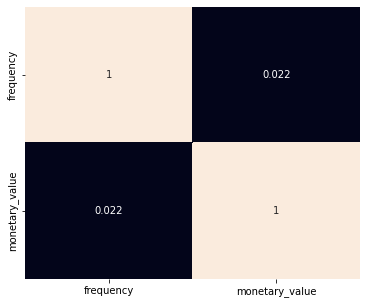

In [43]:
plt.figure(figsize=(6,5))
sns.heatmap(ggf_filter[["frequency", "monetary_value"]].corr(), annot = True, cbar = False)

In [44]:
ggf_model =  lifetimes.GammaGammaFitter(penalizer_coef=0.1)

In [45]:
ggf_model.fit(ggf_filter["frequency"], ggf_filter["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 4189 subjects, p: 1.02, q: 0.18, v: 0.93>

In [46]:
ggf_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,1.019926,0.024531,0.971846,1.068006
q,0.179152,0.002996,0.173280,0.185023
v,0.933467,0.025489,0.883508,0.983426


In [47]:
ggf_filter["expected_avg_sales_"] = ggf_model.conditional_expected_average_profit(ggf_filter["frequency"],
                                                                                     ggf_filter["monetary_value"])

In [48]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482,12504.444869
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570,695.851861
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788,562.775388
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988,1531.122915
6,12352,8.0,356.0,392.0,338.261250,0.012357,0.987643,0.556060,0.674157,0.118098,376.226899


In [49]:
print("Mean Squared Error: %s" %(mean_squared_error(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"])))
print("Root Mean Squared Error: %s" %(sqrt(mean_squared_error(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"]))))
print("R2 Score: %s" %(r2_score(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"])))

Mean Squared Error: 118447363.6217067
Root Mean Squared Error: 10883.352591077195
R2 Score: -15.721908585813079


In [50]:
ggf_filter["predicted_clv"] = ggf_model.customer_lifetime_value(pareto_model,
                                                       ggf_filter["frequency"],
                                                       ggf_filter["recency"],
                                                       ggf_filter["T"],
                                                       ggf_filter["monetary_value"],
                                                       time = 30,
                                                       freq = 'D',
                                                       discount_rate = 0.01)

In [51]:
#Top 5 customers with high CLV
ggf_filter[["CustomerID", "predicted_clv"]].sort_values(by = "predicted_clv", ascending = False).head(5)

,CustomerID,predicted_clv
4061,16446,3.636526e+06
5692,18102,5.048913e+05
2277,14646,4.537431e+05
189,12536,3.626072e+05
5050,17450,2.876695e+05


In [52]:
# Assuming 5% of Profit Margin
ggf_filter["profit_margin"] = ggf_filter["predicted_clv"]*0.05

In [53]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

In [54]:
#exporting the result to csv
ggf_filter.to_csv("customer_lifetime_value_prediction.csv")

**CUSTOMER SEGMENTATION USING PREDICTED CLV**

In [55]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_,predicted_clv,profit_margin
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482,12504.444869,35175.087513,1758.754376
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570,695.851861,7680.254014,384.012701
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788,562.775388,3430.871570,171.543579
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988,1531.122915,5920.276687,296.013834
6,12352,8.0,356.0,392.0,338.261250,0.012357,0.987643,0.556060,0.674157,0.118098,376.226899,4723.422157,236.171108


In [56]:
col = ["predicted_purchases", "expected_avg_sales_", "predicted_clv", "profit_margin"]

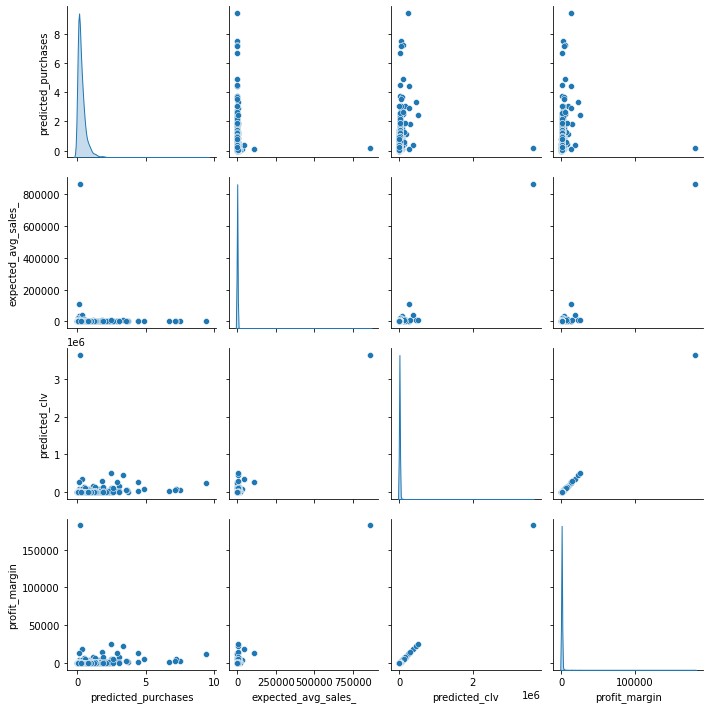

In [57]:
sns.pairplot(ggf_filter[col], diag_kind = "kde")

In [58]:
new_df = ggf_filter[col]
print(new_df)

      predicted_purchases  expected_avg_sales_  predicted_clv  profit_margin
0                0.155209         12504.444869   35175.087513    1758.754376
1                0.485818           695.851861    7680.254014     384.012701
2                0.270791           562.775388    3430.871570     171.543579
3                0.168606          1531.122915    5920.276687     296.013834
6                0.556060           376.226899    4723.422157     236.171108
...                   ...                  ...            ...            ...
5871             0.076241           418.843596     715.310041      35.765502
5872             0.261352           403.576306    2349.822315     117.491116
5873             0.766602           149.398389    2635.503904     131.775195
5876             0.052165          4274.910277    4670.126802     233.506340
5877             0.264345           741.876901    4471.721302     223.586065

[4189 rows x 4 columns]


In [59]:
inertia = []

for i in range(1, 11):
    kmeans  = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(new_df)
    inertia.append(kmeans.inertia_)

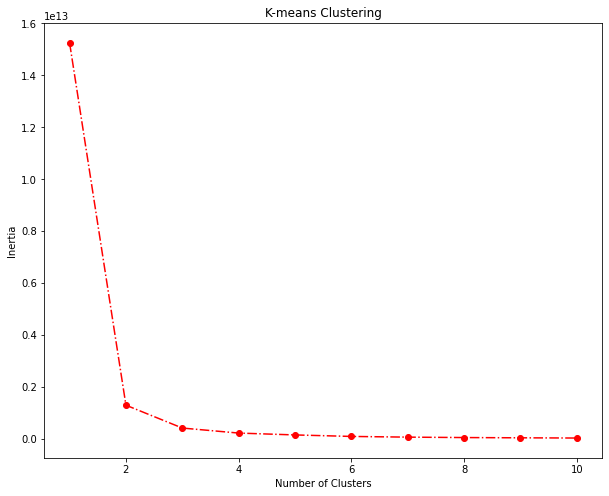

In [60]:
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), inertia, marker = 'o', linestyle = '-.',color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('K-means Clustering')
plt.show()

In [61]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

In [62]:
labels=kmeans.fit(new_df)

In [63]:
df_segm_kmeans= new_df.copy()
df_segm_kmeans['Segment K-means'] = kmeans.labels_

In [64]:
df_segm_analysis = df_segm_kmeans.groupby(['Segment K-means']).mean()
df_segm_analysis

,predicted_purchases,expected_avg_sales_,predicted_clv,profit_margin
Segment K-means,,,,
0,0.324033,758.436149,4.105923e+03,205.296136
1,0.187433,863116.959561,3.636526e+06,181826.302865
2,3.103728,22851.858246,3.334814e+05,16674.070021
3,2.046050,4194.432976,7.971578e+04,3985.789230


In [65]:
df_segm_analysis.rename({0:'Low',
                         1:'Very-High',
                         2:'High',
                         3:'Medium'})

,predicted_purchases,expected_avg_sales_,predicted_clv,profit_margin
Segment K-means,,,,
Low,0.324033,758.436149,4.105923e+03,205.296136
Very-High,0.187433,863116.959561,3.636526e+06,181826.302865
High,3.103728,22851.858246,3.334814e+05,16674.070021
Medium,2.046050,4194.432976,7.971578e+04,3985.789230


In [66]:
# Add the segment labels to our table
df_segm_kmeans['Labels'] = df_segm_kmeans['Segment K-means'].map({0:'Low',
                                                                  1:'Very-High',
                                                                  2:'High',
                                                                  3:'Medium'})

In [67]:
df_segm_kmeans.head()

,predicted_purchases,expected_avg_sales_,predicted_clv,profit_margin,Segment K-means,Labels
0,0.155209,12504.444869,35175.087513,1758.754376,0,Low
1,0.485818,695.851861,7680.254014,384.012701,0,Low
2,0.270791,562.775388,3430.871570,171.543579,0,Low
3,0.168606,1531.122915,5920.276687,296.013834,0,Low
6,0.556060,376.226899,4723.422157,236.171108,0,Low


In [68]:
ggf_filter = pd.concat([ggf_filter,df_segm_kmeans['Segment K-means'],df_segm_kmeans['Labels']], axis = 1)

In [69]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_,predicted_clv,profit_margin,Segment K-means,Labels
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482,12504.444869,35175.087513,1758.754376,0,Low
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570,695.851861,7680.254014,384.012701,0,Low
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788,562.775388,3430.871570,171.543579,0,Low
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988,1531.122915,5920.276687,296.013834,0,Low
6,12352,8.0,356.0,392.0,338.261250,0.012357,0.987643,0.556060,0.674157,0.118098,376.226899,4723.422157,236.171108,0,Low


In [70]:
ggf_filter.groupby('Labels').CustomerID.count()/ggf_filter.CustomerID.count()*100

Labels
High          0.190976
Low          98.925758
Medium        0.859394
Very-High     0.023872
Name: CustomerID, dtype: float64

In [71]:
ggf_filter.to_csv("Segmentation_result.csv")

In [73]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(new_df)

PCA()

In [74]:
pca.explained_variance_ratio_
pca.explained_variance_ratio_.cumsum()

array([0.99665854, 1.        , 1.        , 1.        ])

Text(0, 0.5, 'cumculative explained variance')

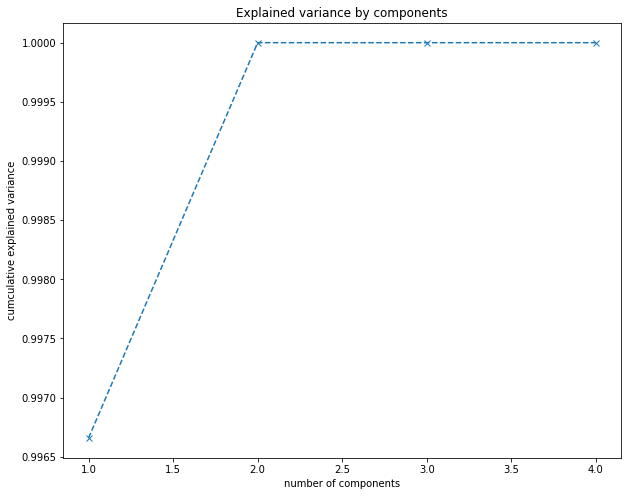

In [77]:
plt.figure(figsize=(10,8))
plt.plot(range(1,5), pca.explained_variance_ratio_.cumsum(), marker='x', linestyle="--")
plt.title('Explained variance by components')
plt.xlabel('number of components')
plt.ylabel('cumculative explained variance')

In [78]:
# as rule of thumb, we take the number of components that account for 80% of the explained variance
pca2 = PCA(n_components=2)

In [79]:
pca2.fit(new_df)

PCA(n_components=2)

In [80]:
pca2.transform(new_df)
score_pca2 = pca2.transform(new_df)

In [82]:
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state=42)
    kmeans_pca.fit(score_pca2)
    wcss.append(kmeans_pca.inertia_)

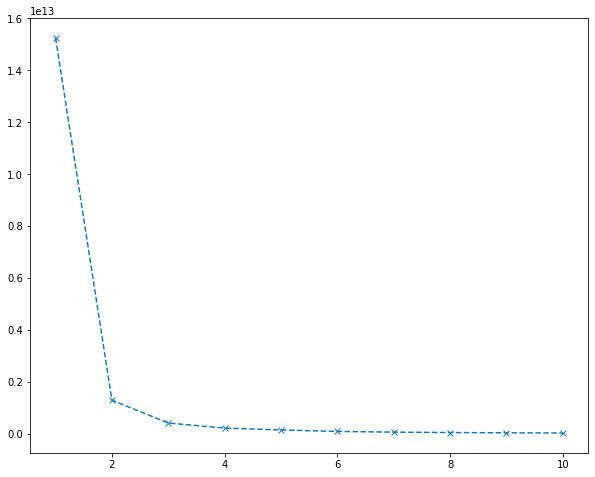

In [83]:
plt.figure(figsize=(10,8))
plt.plot(range(1,11), wcss, marker='x', linestyle='--')

In [84]:
# from the graph above, we choose 3 as the number of clusters since the curve becomes smoother after 3
kmeans_pca = KMeans(n_clusters= 3, init='k-means++', random_state= 20)

In [85]:
kmeans_pca.fit_transform(score_pca2)

array([[3.27064878e+04, 3.70482048e+06, 2.66030646e+05],
       [3.00736763e+03, 3.73432903e+06, 2.94057955e+05],
       [1.26851817e+03, 3.73849954e+06, 2.98312622e+05],
       ...,
       [2.14190489e+03, 3.73936980e+06, 2.99133462e+05],
       [3.48868780e+03, 3.73643722e+06, 2.96864611e+05],
       [2.11240697e+02, 3.73744418e+06, 2.97261344e+05]])

In [86]:
pd.DataFrame(score_pca2)

,0,1
0,30756.836178,-4917.885008
1,1322.416127,642.112203
2,-2859.948086,-150.310188
3,-216.785340,-555.301936
4,-1636.997699,312.352156
...,...,...
4184,-5545.447807,-599.217443
4185,-3951.119997,-229.540041
4186,-3726.984257,80.601233
4187,-843.931871,-3505.189771


In [89]:
df2_pca_kmeans = pd.concat([ggf_filter.reset_index(drop=True), \
    pd.DataFrame(score_pca2)], axis=1)
df2_pca_kmeans.columns.values[-2:] = ['pc1', 'pc2']

df2_pca_kmeans['cluster'] = kmeans_pca.labels_

In [90]:
df2_pca_kmeans.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_,predicted_clv,profit_margin,Segment K-means,Labels,pc1,pc2,cluster
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482,12504.444869,35175.087513,1758.754376,0,Low,30756.836178,-4917.885008,0
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570,695.851861,7680.254014,384.012701,0,Low,1322.416127,642.112203,0
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788,562.775388,3430.871570,171.543579,0,Low,-2859.948086,-150.310188,0
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988,1531.122915,5920.276687,296.013834,0,Low,-216.785340,-555.301936,0
4,12352,8.0,356.0,392.0,338.261250,0.012357,0.987643,0.556060,0.674157,0.118098,376.226899,4723.422157,236.171108,0,Low,-1636.997699,312.352156,0


In [91]:
df2_pca_kmeans['cluster'] = df2_pca_kmeans['cluster'].map({0:'First', 1:'Second', 2:'Third'})
df2_pca_kmeans.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_,predicted_clv,profit_margin,Segment K-means,Labels,pc1,pc2,cluster
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482,12504.444869,35175.087513,1758.754376,0,Low,30756.836178,-4917.885008,First
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570,695.851861,7680.254014,384.012701,0,Low,1322.416127,642.112203,First
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788,562.775388,3430.871570,171.543579,0,Low,-2859.948086,-150.310188,First
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988,1531.122915,5920.276687,296.013834,0,Low,-216.785340,-555.301936,First
4,12352,8.0,356.0,392.0,338.261250,0.012357,0.987643,0.556060,0.674157,0.118098,376.226899,4723.422157,236.171108,0,Low,-1636.997699,312.352156,First


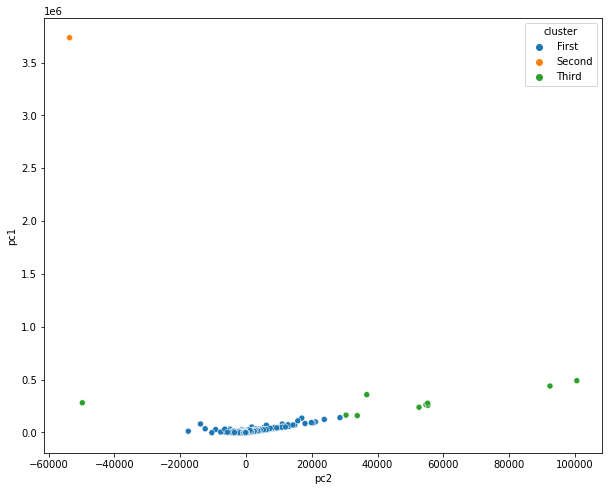

In [92]:
plt.figure(figsize = (10,8))
sns.scatterplot(x='pc2', y='pc1', data=df2_pca_kmeans, hue='cluster', hue_order=['First', 'Second','Third'])

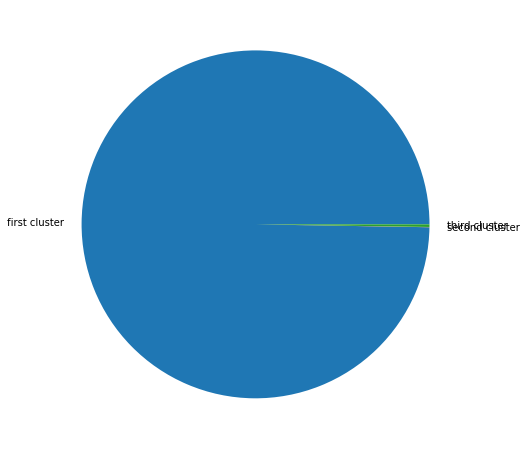

In [93]:
plt.figure(figsize = (8,8))
pie = df2_pca_kmeans.groupby(['cluster']).size().to_frame().reset_index()
pie.rename(columns={0: 'count'}, inplace=True)

pie_labels = ['first cluster', 'second cluster', 'third cluster']
plt.pie(pie['count'], labels=pie_labels)
plt.show()

In [95]:
df2_pca_kmeans.groupby('cluster').CustomerID.count()/df2_pca_kmeans.CustomerID.count()*100

cluster
First     99.737407
Second     0.023872
Third      0.238720
Name: CustomerID, dtype: float64